In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [3]:
import numpy as np
import pandas as pd
import os
import torch
# from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import  Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from skimage.morphology import label
import cv2

In [4]:
train_data = os.listdir('/kaggle/input/airbus-ship-detection/train_v2')
test_data = os.listdir('/kaggle/input/airbus-ship-detection/test_v2')


image_path_train = '/kaggle/input/airbus-ship-detection/train_v2'
image_path_test = '/kaggle/input/airbus-ship-detection/test_v2'

In [5]:
submission = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [6]:
mask = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
display(mask.head(5))
print((mask.shape))

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


(231723, 2)


In [7]:
empty_ship = mask['EncodedPixels'].isna().sum()
print('Empty image without ships: ',empty_ship)

Containing_ship = mask['EncodedPixels'].notna().sum()
print('Image containing ships: ',Containing_ship)

Empty image without ships:  150000
Image containing ships:  81723


In [8]:
df = mask.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0
...,...,...
fffedbb6b.jpg,0,0
ffff2aa57.jpg,0,0
ffff6e525.jpg,0,0


In [9]:
mask['ships'] = mask['EncodedPixels'].map(lambda x: 1 if not pd.isna(x) else 0)
mask


,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [10]:
filtered_image_ids = set(mask['ImageId'].unique()) 

train_data_2 = [x for x in train_data if x in filtered_image_ids]
set(train_data_2)
len(train_data_2)

192556

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_names = df.loc[df['ships'] == 1, 'ImageId'].tolist()
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

#         mask = self.masks_as_image(self.df.query('ImageId == "image_name"')['EncodedPixels'])
        mask = self.masks_as_image(self.df.query(f'ImageId == "{image_name}"')['EncodedPixels'])

        

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask > 0).float() 
            
#             image = image/255.0
                 
        return image, mask
    
    def rle_decode(self, mask_rle, shape=(768, 768)):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T 
    
    def masks_as_image(self, mask_list):
        # Take the individual ship masks and create a single mask array for all ships
        mask = np.zeros((768, 768), dtype=np.uint8)

        # Check if mask_list is not a float (i.e., it's not a single value)
        if not isinstance(mask_list, float):
            if isinstance(mask_list, str):
                mask |= self.rle_decode(mask_list)
            elif pd.notna(mask_list).any():
                for massk in mask_list:
                    if isinstance(massk, str):
                        mask |= self.rle_decode(massk)

        return Image.fromarray(mask)  # Convert NumPy array to PIL Image object
    
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

batch_size = 28

# Create dataset instance
dataset = CustomDataset(df=mask, image_dir=image_path_train, transform=transform)

len(dataset)

81723

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class CustomDataset_for_test_data(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_names = os.listdir(self.image_dir)
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
                 
        return image
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

batch_size = 28

dataset_test = CustomDataset_for_test_data(image_dir=image_path_test, transform = transform)
len(dataset_test)

15606

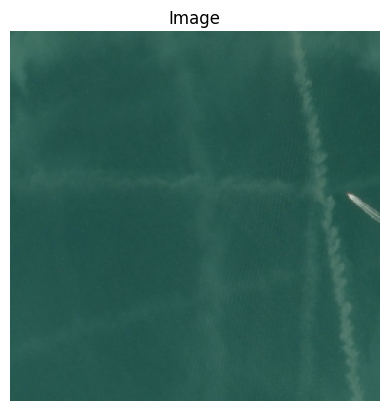

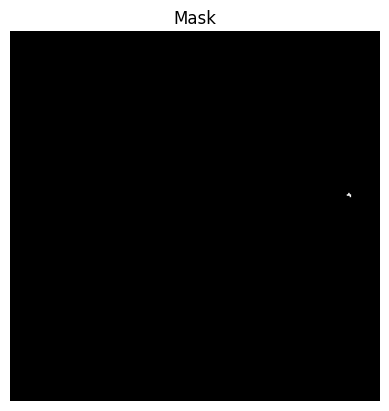

In [13]:
imagee, maskk = dataset[150]

import matplotlib.pyplot as plt
plt.imshow(imagee.permute(1, 2, 0)) 
plt.title('Image')
plt.axis('off')
plt.show()


plt.imshow(maskk[0], cmap='gray') 
plt.title('Mask')
plt.axis('off')
plt.show()

In [14]:
maskk.unique()

tensor([0., 1.])

In [15]:
size = maskk.size()
size
image_size = imagee.size()
image_size

torch.Size([3, 256, 256])

In [16]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_data_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers= 4)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers= 4)

print(len(train_dataset))
print(len(test_dataset))

65378
16345


In [17]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels,
                      output_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, 
                      output_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Down part of Unet
        for feature in features:
            self.downs.append(DoubleConv(input_channels, feature))  
            input_channels = feature

        # Up part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2,
                                   feature,
                                   kernel_size=2,
                                   stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1) 

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])  
            concat_skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip_connection)

#         return torch.sigmoid(self.final_conv(x))
        return self.final_conv(x)


def test():
    x = torch.rand(size=(32, 1, 256,
                         256)) 
    model = Unet(input_channels = 1, output_channels=1)
    prediction = model(x)
    print(x.shape)
    print(prediction.shape)
    assert prediction.shape == x.shape

test()

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


In [18]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print('Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

In [19]:
def check_accuracy(loader, model, device = 'cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f'Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}')
    print(f'Dice score: {dice_score/len(loader)}')
    model.train()

In [20]:
def check_accuracy_1(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    predicted_masks = []

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            predicted_masks.append(preds.cpu().numpy())

    print(f'Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}')
    print(f'Dice score: {dice_score/len(loader)}')
    model.train()

    return predicted_masks

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unet(input_channels=3, output_channels=1).to(device) 

Epoch 1/1


100%|██████████| 2335/2335 [57:12<00:00,  1.47s/it, loss=0.469]


Train Accuracy: 0.8035
Validation Accuracy: 0.9893
Saving checkpoint


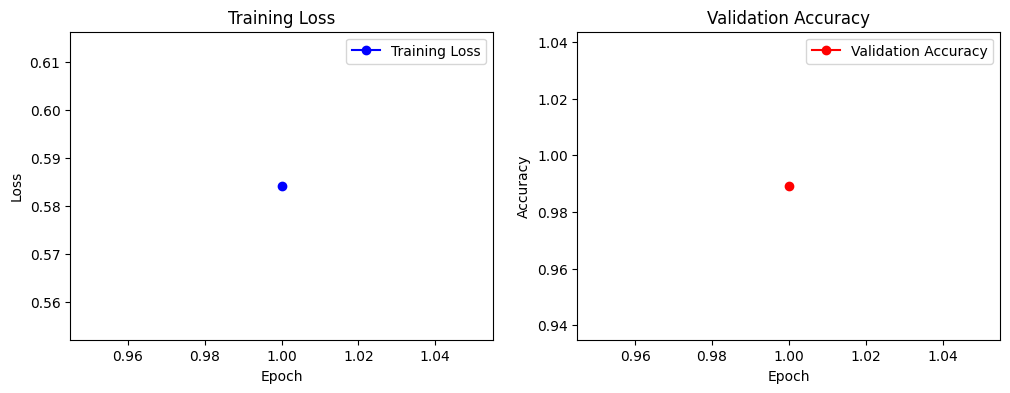

In [22]:
import torch
from tqdm import tqdm
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

learning_rate = 1e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1
num_workers = 10
pin_memory = True

# Initialize lists to store losses and accuracies
train_losses = []
val_accuracies = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    correct = 0
    total = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(device)
        target = target.float().to(device)
        
        # Forward
        predictions = model(data)
        loss = loss_fn(predictions, target)
        train_loss += loss.item()
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.round(torch.sigmoid(predictions))
        correct += (preds == target).sum().item()
        total += target.numel()
        
        # Update tqdm loop
        loop.set_postfix(loss=loss.item())
    
    accuracy = correct / total
    train_losses.append(train_loss / len(loader))
    return accuracy

def check_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.float().to(device)
            predictions = model(data)
            preds = torch.round(torch.sigmoid(predictions))
            correct += (preds == target).sum().item()
            total += target.numel()
    
    model.train()
    return correct / total

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)        

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_accuracy = train_fn(train_data_loader, model, optimizer, loss_fn)
    val_accuracy = check_accuracy(test_data_loader, model, device)
    
    # Save validation accuracy
    val_accuracies.append(val_accuracy)
    
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoint
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    torch.save(model.state_dict(), 'actually5_18.pth')

# Plot training loss and validation accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [23]:
predicted_masks = check_accuracy_1(test_data_loader, model, device=device)

Got 1059694515/1071185920 with accuracy 98.93
Dice score: 0.015234553255140781


In [24]:
import pickle
with open('model_state_dict.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = torch.sigmoid(self.upconv3(x))
        return x

model = SimpleCNN().to(device)


Epoch 1/5


100%|██████████| 2335/2335 [12:15<00:00,  3.17it/s, loss=0.701]


Train Accuracy: 0.0065
Validation Accuracy: 0.0064
Saving checkpoint
Epoch 2/5


100%|██████████| 2335/2335 [12:03<00:00,  3.23it/s, loss=0.694]


Train Accuracy: 0.0065
Validation Accuracy: 0.0064
Saving checkpoint
Epoch 3/5


100%|██████████| 2335/2335 [11:57<00:00,  3.25it/s, loss=0.693]


Train Accuracy: 0.0065
Validation Accuracy: 0.0064
Saving checkpoint
Epoch 4/5


100%|██████████| 2335/2335 [11:57<00:00,  3.25it/s, loss=0.693]


Train Accuracy: 0.0164
Validation Accuracy: 0.0342
Saving checkpoint
Epoch 5/5


 19%|█▉        | 439/2335 [02:15<10:02,  3.15it/s, loss=0.693]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2335/2335 [11:57<00:00,  3.26it/s, loss=0.693]


Train Accuracy: 0.0402
Validation Accuracy: 0.0504
Saving checkpoint


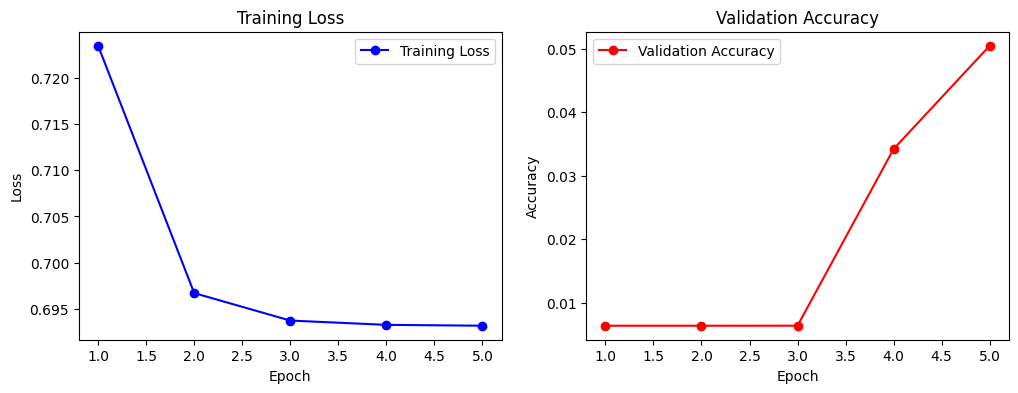

In [35]:
import torch
from tqdm import tqdm
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

learning_rate = 1e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 5  # You can set the number of epochs you need
num_workers = 10
pin_memory = True

# Initialize lists to store losses and accuracies
train_losses = []
val_accuracies = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    correct = 0
    total = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(device)
        target = target.float().to(device)
        
        # Forward
        predictions = model(data)
        loss = loss_fn(predictions, target)
        train_loss += loss.item()
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.round(torch.sigmoid(predictions))
        correct += (preds == target).sum().item()
        total += target.numel()
        
        # Update tqdm loop
        loop.set_postfix(loss=loss.item())
    
    accuracy = correct / total
    train_losses.append(train_loss / len(loader))
    return accuracy

def check_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.float().to(device)
            predictions = model(data)
            preds = torch.round(torch.sigmoid(predictions))
            correct += (preds == target).sum().item()
            total += target.numel()
    
    model.train()
    return correct / total

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)        

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_accuracy = train_fn(train_data_loader, model, optimizer, loss_fn)
    val_accuracy = check_accuracy(test_data_loader, model, device)
    
    # Save validation accuracy
    val_accuracies.append(val_accuracy)
    
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoint
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    torch.save(model.state_dict(), 'actually5_18.pth')

# Plot training loss and validation accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetSegmentation, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.base_layers = nn.Sequential(*list(resnet.children())[:-2])
        
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv5 = nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.base_layers(x)
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = F.relu(self.upconv4(x))
        x = torch.sigmoid(self.upconv5(x))
        return x

modelr = ResNetSegmentation().to(device)


Epoch 1/5


100%|██████████| 2335/2335 [11:57<00:00,  3.25it/s, loss=0.693]


Train Accuracy: 0.2074
Validation Accuracy: 0.3258
Saving checkpoint
Epoch 2/5


100%|██████████| 2335/2335 [12:00<00:00,  3.24it/s, loss=0.693]


Train Accuracy: 0.3969
Validation Accuracy: 0.4845
Saving checkpoint
Epoch 3/5


100%|██████████| 2335/2335 [11:53<00:00,  3.27it/s, loss=0.693]


Train Accuracy: 0.6082
Validation Accuracy: 0.7372
Saving checkpoint
Epoch 4/5


100%|██████████| 2335/2335 [11:54<00:00,  3.27it/s, loss=0.693]


Train Accuracy: 0.8412
Validation Accuracy: 0.9138
Saving checkpoint
Epoch 5/5


100%|██████████| 2335/2335 [11:55<00:00,  3.26it/s, loss=0.693]


Train Accuracy: 0.9541
Validation Accuracy: 0.9813
Saving checkpoint


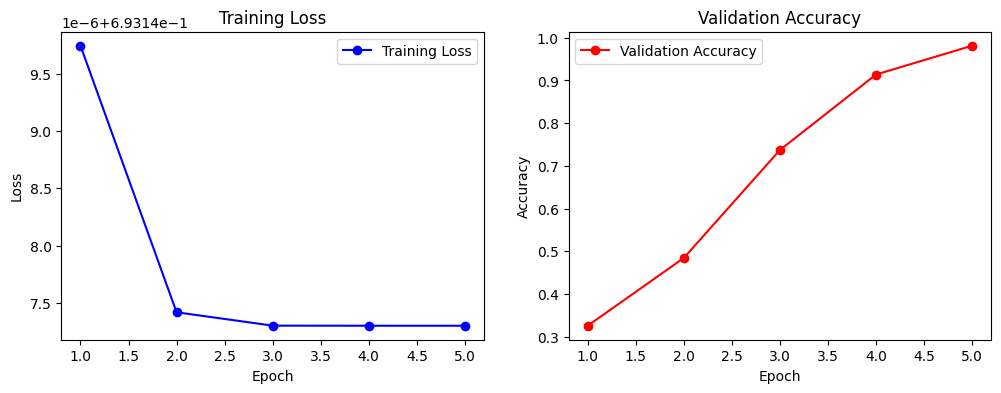

In [37]:
import torch
from tqdm import tqdm
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

learning_rate = 1e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 5  # You can set the number of epochs you need
num_workers = 10
pin_memory = True

# Initialize lists to store losses and accuracies
train_losses = []
val_accuracies = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    correct = 0
    total = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(device)
        target = target.float().to(device)
        
        # Forward
        predictions = model(data)
        loss = loss_fn(predictions, target)
        train_loss += loss.item()
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.round(torch.sigmoid(predictions))
        correct += (preds == target).sum().item()
        total += target.numel()
        
        # Update tqdm loop
        loop.set_postfix(loss=loss.item())
    
    accuracy = correct / total
    train_losses.append(train_loss / len(loader))
    return accuracy

def check_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.float().to(device)
            predictions = model(data)
            preds = torch.round(torch.sigmoid(predictions))
            correct += (preds == target).sum().item()
            total += target.numel()
    
    model.train()
    return correct / total

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)        

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_accuracy = train_fn(train_data_loader, model, optimizer, loss_fn)
    val_accuracy = check_accuracy(test_data_loader, model, device)
    
    # Save validation accuracy
    val_accuracies.append(val_accuracy)
    
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoint
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    torch.save(model.state_dict(), 'resnet_segmentation.pth')

# Plot training loss and validation accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [38]:
import pickle
with open('RNS_model', 'wb') as f:
    pickle.dump(model.state_dict(), f)